In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy

import sys
from pathlib import Path
fun_lib_path = Path.home() / 'git/alexei_fun_lib' 
sys.path.append(str(fun_lib_path))

import matplotlib_funs as mpf
import graph_funs as grf
import numerical_funs as nf
import general_funs as gef
import optics_funs as of
import finesse3_funs as f3f
import LCT_funs as lctf

import finesse
import finesse.ligo

import networkx as nx

In [3]:
from finesse.ligo import aligo_katscript

In [4]:
code = '''
# modulators for core interferometer sensing - Advanced LIGO, CQG, 2015
# http://iopscience.iop.org/article/10.1088/0264-9381/32/7/074001/meta#cqg507871s4-8
# 9MHz (CARM, PRC, SRC loops)
variable f1 9099471
variable f2 5*&f1
variable nsilica 1.45
variable Mloss 30u
###############################################################################
###   length definitions
###############################################################################
variable Larm 3994
variable LPR23 16.164  # distance between PR2 and PR3
variable LSR23 15.443  # distance between SR2 and SR3
variable LPR3BS 19.538 # distance between PR3 and BS
variable LSR3BS 19.366 # distance between SR3 and BS
variable lmich 5.342   # average length of MICH
variable lschnupp 0.08
variable lPRC (3+0.5)*c0/(2*&f1) # T1000298 Eq2.1, N=3
variable lSRC (17)*c0/(2*&f2) # T1000298 Eq2.2, M=3
###############################################################################
###   laser
###############################################################################
laser L0 P=125
mod mod1 f=&f1 midx=0.18 order=1 mod_type=pm
mod mod2 f=&f2 midx=0.18 order=1 mod_type=pm
link(L0, mod1, mod2)
###############################################################################
###   PRC
###############################################################################
s sPRCin mod2.p2 PRMAR.p1
m PRMAR R=0 L=40u xbeta=&PRM.xbeta ybeta=&PRM.ybeta phi=&PRM.phi
s sPRMsub1 PRMAR.p2 PRM.p1 L=0.0737 nr=&nsilica
m PRM T=0.03 L=8.5u Rc=11.009
s lp1 PRM.p2 PR2.p1 L=&lPRC-&LPR3BS-&LPR23-&lmich
bs PR2 T=250u L=&Mloss alpha=-0.79 Rc=-4.545
s lp2 PR2.p2 PR3.p1 L=&LPR23
bs PR3 T=0 L=&Mloss alpha=0.615 Rc=36.027
s lp3 PR3.p2 BS.p1 L=&LPR3BS
###############################################################################
###   BS
###############################################################################
bs BS R=0.5 L=&Mloss alpha=45
s BSsub1 BS.p3 BSAR1.p1 L=0.0687 nr=&nsilica
s BSsub2 BS.p4 BSAR2.p2 L=0.0687 nr=&nsilica
bs BSAR1 L=50u R=0 alpha=-29.195
bs BSAR2 L=50u R=0 alpha=29.195
###############################################################################
###   Yarm
###############################################################################
# Distance from beam splitter to Y arm input mirror
s ly1 BS.p2 ITMYlens.p1 L=&lmich-&lschnupp/2-&ITMYsub.L*&ITMXsub.nr
lens ITMYlens f=34500
s ly2 ITMYlens.p2 ITMYAR.p1
m ITMYAR R=0 L=20u xbeta=&ITMY.xbeta ybeta=&ITMY.ybeta phi=&ITMY.phi
s ITMYsub ITMYAR.p2 ITMY.p1 L=0.2 nr=&nsilica
m ITMY T=0.014 L=&Mloss Rc=-1934
s LY ITMY.p2 ETMY.p1 L=&Larm
m ETMY T=5u L=&Mloss Rc=2245
s ETMYsub ETMY.p2 ETMYAR.p1 L=0.2 nr=&nsilica
m ETMYAR 0 500u xbeta=&ETMY.xbeta ybeta=&ETMY.ybeta phi=&ETMY.phi
cav cavYARM ETMY.p1.o
###############################################################################
###   Xarm
###############################################################################
# Distance from beam splitter to X arm input mirror
s lx1 BSAR1.p3 ITMXlens.p1 L=&lmich+&lschnupp/2-&ITMXsub.L*&ITMXsub.nr-&BSsub1.L*&BSsub1.nr
lens ITMXlens f=34500
s lx2 ITMXlens.p2 ITMXAR.p1
m ITMXAR R=0 L=20u xbeta=&ITMX.xbeta ybeta=&ITMX.ybeta phi=&ITMX.phi
s ITMXsub ITMXAR.p2 ITMX.p1 L=0.2 nr=&nsilica
m ITMX T=0.014 L=&Mloss Rc=-1934
s LX ITMX.p2 ETMX.p1 L=&Larm
m ETMX T=5u L=&Mloss Rc=2245
s ETMXsub ETMX.p2 ETMXAR.p1 L=0.2 nr=&nsilica
m ETMXAR 0 500u xbeta=&ETMX.xbeta ybeta=&ETMX.ybeta phi=&ETMX.phi
cav cavXARM ETMX.p1.o
###############################################################################
###   SRC
###############################################################################
s ls3 BSAR2.p4 SR3.p1 L=&LSR3BS
bs SR3 T=0 L=&Mloss alpha=0.785 Rc=35.972841
s ls2 SR3.p2 SR2.p1 L=&LSR23
bs SR2 T=0 L=&Mloss alpha=-0.87 Rc=-6.406
s ls1 SR2.p2 SRM.p1 L=&lSRC-&LSR3BS-&LSR23-&BSsub2.L*&BSsub2.nr-&lmich
m SRM T=0.2 L=8.7u Rc=-5.6938
s SRMsub SRM.p2 SRMAR.p1 L=0.0749 nr=&nsilica
m SRMAR R=0 L=50n
###############################################################################
###   OMC
###############################################################################
# Here we just use some simple filter to approximate an OMC for filtering
# out RF fields, this doesn't filter HOMs!
dbs OFI
sq sqz db=6 angle=90.0
#obp OMC fc=0 bandwidth=1M filter_hom=[0,0]
link(sqz, OFI.p2)
#link(SRMAR.p2, OFI.p1)
#link(OFI.p3, OMC)

# (as built parameters: D1300507-v1)
s sSRM_OFI SRMAR.p2 OFI.p1 L=0.7278
s sOFI_OM1 OFI.p3 OM1.p1 L=2.9339

bs OM1 T=800u L=&Mloss alpha=2.251 Rc=[4.6, 4.6] # T is set for high power; Loss is a guess
s sOM1_OM2 OM1.p2 OM2.p1 L=1.395
bs OM2 T=10u L=&Mloss alpha=4.399 Rc=[1.7058, 1.7058] # T is a guess
s sOM2_OM3 OM2.p2 OM3.p1 L=0.631
bs OM3 T=10u L=&Mloss alpha=30.037 # T is a guess
s sOM3_OMC OM3.p2 OMC_IC.p1 L=0.2034

bs OMC_IC T=0.0076 L=10u alpha=2.7609 
s lIC_OC OMC_IC.p3 OMC_OC.p1 L=0.2815 
bs OMC_OC T=0.0075 L=10u alpha=4.004
s lOC_CM1 OMC_OC.p2 OMC_CM1.p1 L=0.2842
bs OMC_CM1 T=36u L=10u alpha=4.004 Rc=[2.57321, 2.57321]
s lCM1_CM2 OMC_CM1.p2 OMC_CM2.p1 L=0.2815
bs OMC_CM2 T=35.9u L=10u alpha=4.004 Rc=[2.57369, 2.57369]
s lCM2_IC OMC_CM2.p2 OMC_IC.p4 L=0.2842
###############################################################################
### Length sensing and control
###############################################################################
dof XARM ETMX.dofs.z
dof YARM ETMY.dofs.z
dof CARM ETMX.dofs.z +1 ETMY.dofs.z +1
dof DARM ETMX.dofs.z +1 ETMY.dofs.z -1
dof PRCL PRM.dofs.z +1
dof SRCL SRM.dofs.z +1 DC=90
dof MICH BS.dofs.z +1
dof MICH2 ITMY.dofs.z +1 ETMY.dofs.z +1 ITMX.dofs.z -1 ETMX.dofs.z -1
dof STRAIN LX.dofs.h +1 LY.dofs.h -1
dof FRQ L0.dofs.frq
dof RIN L0.dofs.amp

readout_rf REFL9 PRMAR.p1.o f=&f1
readout_rf REFL18 PRMAR.p1.o f=3*&f1
readout_rf REFL45 PRMAR.p1.o f=5*&f1
readout_rf POP9  PR2.p3.o   f=&f1
readout_rf POP45 PR2.p3.o   f=&f2
readout_rf AS45  SRMAR.p2.o f=&f2
readout_dc AS    OMC_OC.p3.o

lock CARM_lock REFL9.outputs.I CARM.DC -0.1 1e-6
lock MICH_lock POP45.outputs.Q MICH.DC -15 1e-6
lock PRCL_lock POP9.outputs.I PRCL.DC 2.8 1e-6
lock SRCL_lock POP45.outputs.I SRCL.DC 42 1e-6
lock DARM_rf_lock AS45.outputs.I DARM.DC -0.003 1e-6
lock DARM_dc_lock AS.outputs.DC DARM.DC -0.003 1e-6 offset=20m disabled=true
###############################################################################
### DC power measurements
###############################################################################
pd Px ETMX.p1.i
pd Py ETMX.p1.i
pd Pprc PRM.p2.o
pd Psrc SRM.p1.i
pd Prefl ETMX.p1.i
pd Pas OMC_OC.p3.o
###############################################################################
###   Cavity definitions
###############################################################################
cav PRX PRM.p2.o ITMX.p1.i
cav PRY PRM.p2.o ITMY.p1.i
cav ARMY ITMY.p2.o
cav ARMX ITMX.p2.o
cav SRX SRM.p1.o ITMX.p1.i
cav SRY SRM.p1.o ITMY.p1.i
cav OMC OMC_IC.p3.o
'''

In [5]:
kat = finesse.model.Model()
kat.parse(code)
kat.beam_trace()

<BeamTraceSolution of beam_trace @ 0x7fa68775f280 children=0>

In [6]:
kat = finesse.ligo.make_aligo()
kat.parse('''
cav PRX PRM.p2.o ITMX.p1.i
cav PRY PRM.p2.o ITMY.p1.i
cav SRX SRM.p1.o ITMX.p1.i
cav SRY SRM.p1.o ITMY.p1.i
cav OMC OMC_IC.p3.o
''')
kat.beam_trace()

<BeamTraceSolution of beam_trace @ 0x7fa685eb1a60 children=0>

In [13]:
1/35.972841 - 1/(35.972841+32e-3)

2.470667729846665e-05

In [12]:
1/(35.972841+32e-3)

0.027774042940503472

In [8]:
kat.SR3.Rc

array([ 35.972841,  35.972841])

In [12]:
def path_via_nodes(G, nodes):
    node_pairs = zip(nodes, nodes[1:])
    current_path = [nodes[0]]
    for ni,no in node_pairs:
        path = nx.shortest_path(G, ni, no)
        current_path.extend(path[1:])
    
    return current_path

In [13]:
path = path_via_nodes(kat.optical_network, ['L0.p1.o', 'PRM.p2.o', 'ITMY.p1.i', 'SRM.p2.o', 'OMC_IC.p1.i'])
# path = path_via_nodes(kat.optical_network, ['PRM.p2.o', 'ITMX.p2.o'])
# path

In [14]:
edge_list = grf.path_to_edge_list(path)

In [15]:
abcds_x = []
abcds_y = []
for edge in edge_list:
    comp = kat.optical_network.edges[edge]['owner']()
    abcd_x = comp.ABCD(*f3f.get_nodes(kat, edge), direction='x', symbolic=True)
    abcd_y = comp.ABCD(*f3f.get_nodes(kat, edge), direction='y', symbolic=True)
    abcds_x.append(abcd_x)
    abcds_y.append(abcd_y)
abcds_x = abcds_x[::-1]
abcds_y = abcds_y[::-1]

In [16]:
qx = kat.L0.p1.o.qx.q

# define SR3 changes for actuation
dRs = np.linspace(0,32e-3,10)

In [17]:
out = []

mx = gef.matmul_reduce([f3f.map_eval(x) for x in abcds_x])
of.q.propag(qx, mx)

(-0.13517342269167648+0.71996393881151011j)

In [18]:
kat.OMC_IC.p1.i.qx.q

(-0.15284148739534978+0.7206945338901792j)

* start at OMC eigenmode
* make a set of mismatched q-params to OMC by 10%
* for each q-param in the set inverse propagate to SR3
* apply SR3 curvature
* propagate back to OMC
* calculate the new mismatch

In [19]:
ts = np.linspace(0,2*np.pi,13)
ts = ts[0:-1] # remove final point since 0 == 2*np.pi
qOMC_0 = kat.OMC.source.qx.q

# qOMC_10 = of.mismatch_circle(qOMC_0, 0.1, ts)

t_circ = np.linspace(0, 2*np.pi, 151)
circ_10 = of.mismatch_circle(qOMC_0, 0.1, t_circ)
circ_05 = of.mismatch_circle(qOMC_0, 0.05, t_circ)
circ_01 = of.mismatch_circle(qOMC_0, 0.01, t_circ)
circ_001 = of.mismatch_circle(qOMC_0, 0.001, t_circ)

In [199]:
def path_abcd(kat, path):
    path = path_via_nodes(kat.optical_network, path)
    edge_list = grf.path_to_edge_list(path)
    
    abcds_x = []
    for edge in edge_list:
        comp = kat.optical_network.edges[edge]['owner']()
        abcd_x = comp.ABCD(*f3f.get_nodes(kat, edge), direction='x', symbolic=False)
        abcds_x.append(abcd_x)
    abcds_x = abcds_x[::-1]
    
    return gef.matmul_reduce(abcds_x, initial=np.eye(2))

In [200]:
m_SR3_io = path_abcd(kat, ['SR3.p1.i', 'SR3.p2.o'])
minv_SR3_oi = np.linalg.inv(m_SR3_io)

m_SR3o_to_OMC = path_abcd(kat, ['SR3.p2.o', 'OMC_IC.p3.o'])
minv_OMC_to_SR3o = np.linalg.inv(m_SR3o_to_OMC)

m_SRM_to_OMC = path_abcd(kat, ['SRM.p2.o', 'OMC_IC.p3.o'])
minv_OMC_to_SRM = np.linalg.inv(m_SRM_to_OMC)

m_SR3_to_SRM = path_abcd(kat, ['SR3.p2.o', 'SRM.p2.o'])
minv_SRM_to_SR3 = np.linalg.inv(m_SR3_to_SRM)

In [201]:
path_abcd(kat, ['SR3.p2.o', 'OMC_IC.p3.o'])

array([[ -2.03406864, -36.90386258],
       [ -4.69378442, -85.65039126]])

In [202]:
q_0_after_SRM = of.q.propag(qOMC_0, minv_OMC_to_SRM)
q_10_after_SRM = of.mismatch_circle2(q_0_after_SRM, 0.1, ts)
q_10_after_SR3 = of.q.propag(q_10_after_SRM, minv_SRM_to_SR3)
q_10_before_SR3 = of.q.propag(q_10_after_SR3, minv_SR3_oi)

In [203]:
# the heated SR3 curvature has to be applied to the symbolic expression
dRs = np.linspace(0, 32e-3, 9)
SR3_abcd_sym = kat.SR3.ABCD(kat.SR3.p1.i, kat.SR3.p2.o, symbolic=True, direction='x')
c_term_sym = SR3_abcd_sym[1,0]
c_term_dR = f3f.map_eval(c_term_sym, sym_kwargs={'subs': {kat.SR3.Rcx.ref: kat.SR3.Rcx.value + dRs}})
m_SR3_io_dR = of.abcd.lens_p(-c_term_dR)

In [204]:
q_10_dR_after_SR3 = of.q.propag(q_10_before_SR3, m_SR3_io_dR, mode='outer')
q_10_dR_after_SRM = of.q.propag(q_10_dR_after_SR3, m_SR3_to_SRM)

circ_10_after_SRM = of.q.propag(circ_10, minv_OMC_to_SRM)
circ_05_after_SRM = of.q.propag(circ_05, minv_OMC_to_SRM)
circ_01_after_SRM = of.q.propag(circ_01, minv_OMC_to_SRM)
circ_001_after_SRM = of.q.propag(circ_001, minv_OMC_to_SRM)

In [205]:
## build colormap object for plotting

norm = mpl.colors.Normalize(vmin=np.min(dRs),vmax=np.max(dRs))
# choose the best colormap
c_m = mpl.cm.viridis

# create an object that maps numerical inputs to s_rgb colors for plots
s_m = mpl.cm.ScalarMappable(cmap=c_m, norm=norm)
s_m.set_array([])

(-4.8099284936063702,
 -2.7990472542223612,
 0.48503996953605416,
 2.2227565525825241)

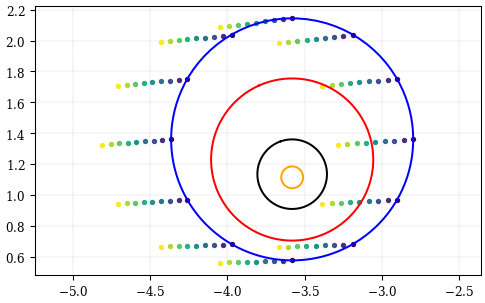

In [206]:
for dR, qset in zip(dRs, q_10_dR_after_SRM.T):
    plt.plot(qset.real, qset.imag, '.', c=s_m.to_rgba(dR),label='_nolegend_')

plt.plot(circ_10_after_SRM.real, circ_10_after_SRM.imag)
plt.plot(circ_05_after_SRM.real, circ_05_after_SRM.imag)
plt.plot(circ_01_after_SRM.real, circ_01_after_SRM.imag)
plt.plot(circ_001_after_SRM.real, circ_001_after_SRM.imag)
plt.axis('equal')

In [207]:
# get q param from alog 41490
q_meas_at_srm_ar = finesse.gaussian.BeamParam(rc=-4.265, w=2e-3).q # from Terra's measurement (vertical only)

/tmp/ipykernel_33086/3761201846.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(s_m)


/home/alexei/git/alexei_thesis/notebooks/commissioning/SR3_heater_contour_model/../SR3_scan_mismatch_contours.png
/home/alexei/git/alexei_thesis/notebooks/commissioning/SR3_heater_contour_model/../SR3_scan_mismatch_contours.pdf


0

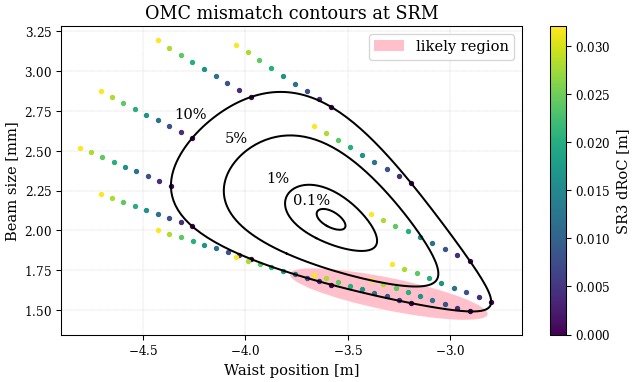

In [241]:
fig, ax = mpf.subplots(1,1, figscale=np.array([9.1, 5])*0.85)

for dR, qset in zip(dRs, q_10_dR_after_SRM.T):
    plt.plot(qset.real, 1e3*of.q.get_w(qset), '.', c=s_m.to_rgba(dR),label='_nolegend_')
    
plt.plot(circ_10_after_SRM.real, 1e3*of.q.get_w(circ_10_after_SRM), c='k')
plt.plot(circ_05_after_SRM.real, 1e3*of.q.get_w(circ_05_after_SRM), c='k')
plt.plot(circ_01_after_SRM.real, 1e3*of.q.get_w(circ_01_after_SRM), c='k')
plt.plot(circ_001_after_SRM.real, 1e3*of.q.get_w(circ_001_after_SRM), c='k')
# plt.plot(np.real(q_meas_at_srm_ar), 1e3*of.q.get_w(q_meas_at_srm_ar),'x',c='r', label='Measured [alog 41490]')
# plt.legend()
cbar = plt.colorbar(s_m)
cbar.set_label('SR3 dRoC [m]')

plt.xlim([-4.9,-2.65])

plt.text(-3.77, 2.16, '0.1%')
plt.text(-3.9, 2.30, '1%')
plt.text(-4.1, 2.55, '5%')
plt.text(-4.35, 2.7, '10%')
# plt.axis('equal')
plt.xlabel('Waist position [m]')
plt.ylabel('Beam size [mm]')
plt.title('OMC mismatch contours at SRM')


ellipse = mpl.patches.Ellipse((0, 0), width=0.2, height=1, facecolor='pink', label='likely region')
transf = mpl.transforms.Affine2D().rotate_deg(75).translate(-3.3,1.6)

ellipse.set_transform(transf + ax[0].transData)
ax[0].add_patch(ellipse)

plt.legend()

mpf.thesis_savefig(fig, '../SR3_scan_mismatch_contours', resize=False)

In [41]:
def propagation_model(q, before, i0, insert, after):
    minv_b = np.linalg.inv(before)
    i0_inv = np.linalg.inv(i0)
    q1s = of.q.propag(q, minv_b)
    q2s = of.q.propag(q1s, i0_inv)
    q3s = of.q.propag(q2s, insert, mode='outer')
    q4s = of.q.propag(q3s, after)
    return q4s

In [51]:
_q_SR3 = propagation_model(q_10_after_SRM, m_SR3_to_SRM, m_SR3_io, m_SR3_io_dR, m_SR3_to_SRM)

In [66]:
m_SR2_io = path_abcd(kat, ['SR2.p1.i', 'SR2.p2.o'])
m_SR2_to_SRM = path_abcd(kat, ['SR2.p2.o', 'SRM.p2.o'])

m_SRM_io = path_abcd(kat, ['SRM.p1.i', 'SRM.p2.o'])
m_SRM_to_SRM = path_abcd(kat, ['SRM.p2.o', 'SRM.p2.o'])

dRs = np.linspace(0, 32e-3, 9)
SR2_abcd_sym = kat.SR2.ABCD(kat.SR2.p1.i, kat.SR2.p2.o, symbolic=True, direction='x')
c_term_sym = SR2_abcd_sym[1,0]
c_term_dR = f3f.map_eval(c_term_sym, sym_kwargs={'subs': {kat.SR2.Rcx.ref: kat.SR2.Rcx.value + dRs}})
m_SR2_io_dR = of.abcd.lens_p(-c_term_dR)

dRs = np.linspace(0, 32e-2, 9)
SRM_abcd_sym = kat.SRM.ABCD(kat.SRM.p1.i, kat.SRM.p2.o, symbolic=True, direction='x')
c_term_sym = SRM_abcd_sym[1,0]
c_term_dR = f3f.map_eval(c_term_sym, sym_kwargs={'subs': {kat.SRM.Rcx.ref: kat.SRM.Rcx.value + dRs}})
m_SRM_io_dR = of.abcd.lens_p(-c_term_dR)

In [67]:
_q_SR2 = propagation_model(q_10_after_SRM, m_SR2_to_SRM, m_SR2_io, m_SR2_io_dR, m_SR2_to_SRM)

_q_SRM = propagation_model(q_10_after_SRM, m_SRM_to_SRM, m_SRM_io, m_SRM_io_dR, m_SRM_to_SRM)

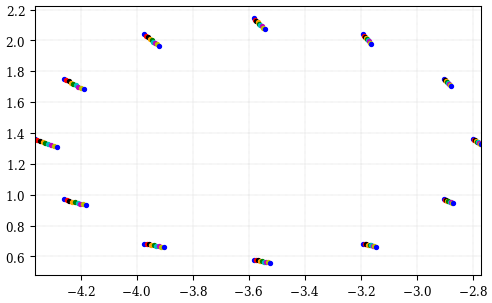

In [68]:
plt.plot(_q_SRM.real, _q_SRM.imag, '.')

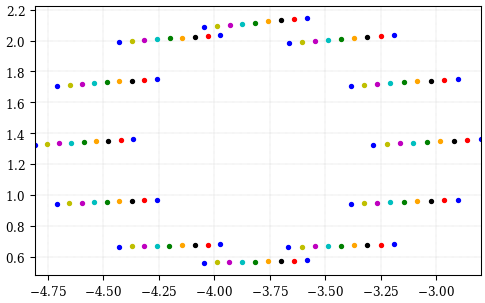

In [54]:
plt.plot(_q_SR3.real, _q_SR3.imag, '.')

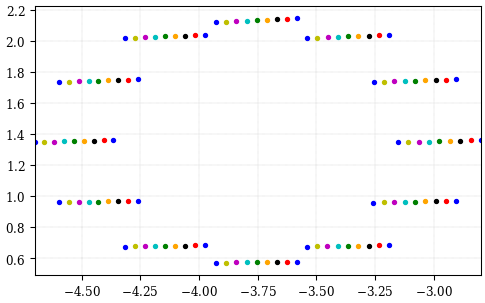

In [50]:
plt.plot(_q_SR2.real, _q_SR2.imag, '.')

In [175]:
def angle_between(x,y):
    d = x-y
    return np.arctan2(np.sin(d), np.cos(d))

def gouy_between(x,y):
    return angle_between(2*x, 2*y)/2

In [194]:
print(gouy_between(kat.SR3.p1.i.qx.gouy(), kat.SRM.p1.i.qx.gouy())/np.pi*180)
print(gouy_between(kat.SR3.p1.i.qx.gouy(), kat.SR2.p1.i.qx.gouy())/np.pi*180)
print(gouy_between(kat.SR3.p1.i.qx.gouy(),kat.ITMY.p1.i.qx.gouy())/np.pi*180)
print(gouy_between(kat.SRM.p1.i.qx.gouy(), kat.SR2.p1.i.qx.gouy())/np.pi*180)
print(gouy_between(kat.SRM.p1.i.qx.gouy(),kat.ITMY.p1.i.qx.gouy())/np.pi*180)
print(gouy_between(kat.ITMY.p1.i.qx.gouy(),kat.SR2.p1.i.qx.gouy())/np.pi*180)

-32.8872294112
-9.94032638402
-18.320597415
22.9469030272
14.5666319962
8.38027103095


In [188]:
print(kat.SRM.p1.i.qx.gouy())
print(kat.SR2.p1.i.qx.gouy())
print(kat.SR3.p1.i.qx.gouy())
print(kat.ITMY.p1.i.qx.gouy())

-1.1566332207
-1.55713223166
1.4109689978
-1.41086890996
